# Synthetic Images from simulated data

- https://learn.astropy.org/tutorials/synthetic-images.html

Learning Goals
- Assign WCS astrometry to an image using astropy.wcs
- Construct a PSF using astropy.modeling.model
- Convolve raw data with PSF using astropy.convolution
- Calculate polarization fraction and angle from Stokes I, Q, U data
- Overplot quivers on the image

In [ ]:
from astropy.utils.data import download_file
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from astropy.convolution import Gaussian2DKernel
from astropy.modeling.models import Lorentz1D
from astropy.convolution import convolve_fft

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## 1. Load and examine the FITS file

Here we begin with a 2-dimensional data that were stored in FITS format from some simulations. We have Stokes I, Q, and U maps. We we'll first load a FITS file and examine the header.

In [ ]:
file_i = download_file(
    'http://data.astropy.org/tutorials/synthetic-images/synchrotron_i_lobe_0700_150MHz_sm.fits', 
    cache=True)

In [ ]:
hdulist = fits.open(file_i)
hdulist.info()

Filename: C:\Users\user\.astropy\cache\download\url\8da27de5aa6b0db633441e82715bedf3\contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  NN_EMISSIVITY_I_LOBE_150.0MHZ    1 ImageHDU        23   (1024, 1452)   float64   


In [ ]:
hdu = hdulist['NN_EMISSIVITY_I_LOBE_150.0MHZ']
hdu.header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1452                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'NN_EMISSIVITY_I_LOBE_150.0MHZ' / extension name                      
BTYPE   = 'nn_emissivity_i_lobe_150.0MHz'                                       
BUNIT   = 'Jy/arcsec**2'                                                        
WCSAXES =                    2                                                  
CRPIX1  =                512.0                                                  
CRPIX2  =                726

We can see this FITS file, which was created in yt, has x and y coordinate in physical units (cm). We want to convert it into sky coordinates. Before we proceed, let's find out the range of the data and plot a histogram.

129.7177858088622
0.0


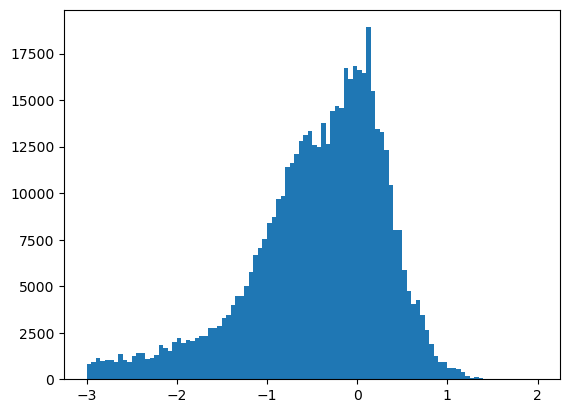

In [ ]:
print(hdu.data.max())
print(hdu.data.min())
np.seterr(divide='ignore') #suppress the warnings raised by taking log10 of data with zeros
plt.hist(np.log10(hdu.data.flatten()), range=(-3, 2), bins=100);

Once we know the range of the data, we can do a visualization with the proper range (vmin and vmax).

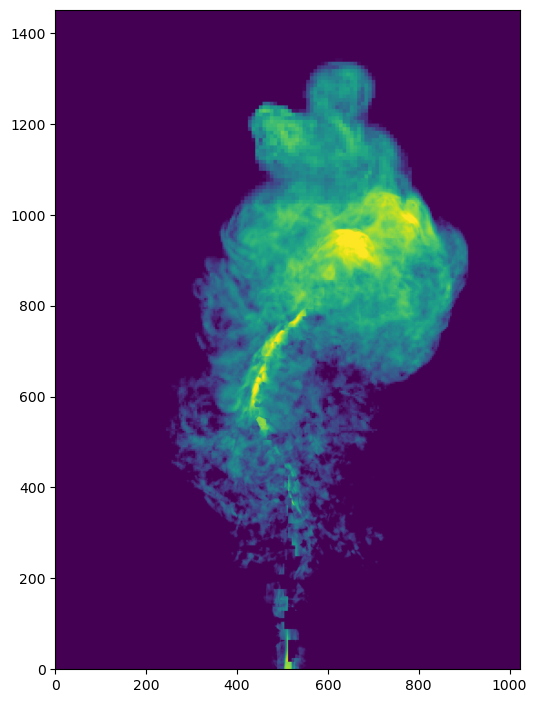

In [ ]:
fig = plt.figure(figsize=(6,12))
fig.add_subplot(111)

# We plot it in log-scale and add a small number to avoid nan values. 
plt.imshow(np.log10(hdu.data+1E-3), vmin=-1, vmax=1, origin='lower')
plt.show()

## 2. Set up astrometry coordinates

From the header, we know that the x and y axes are in centimeter. However, in an observation we usually have RA and Dec. To convert physical units to sky coordinates, we will need to make some assumptions about where the object is located, i.e. the distance to the object and the central RA and Dec.

In [ ]:
# distance to the object
dist_obj = 200*u.Mpc

# We have the RA in hh:mm:ss and DEC in dd:mm:ss format. 
# We will use Skycoord to convert them into degrees later.
ra_obj = '19h59m28.3566s'
dec_obj = '+40d44m02.096s'

Here we convert the pixel scale from cm to degree by dividing the distance to the object.

In [ ]:
cdelt1 = ((hdu.header['CDELT1']*u.cm/dist_obj.to('cm'))*u.rad).to('deg')
cdelt2 = ((hdu.header['CDELT2']*u.cm/dist_obj.to('cm'))*u.rad).to('deg')
print(cdelt1, cdelt2)

8.74922223983974e-06 deg 8.74922223983974e-06 deg


Use astropy.wcs.WCS to prepare a FITS header.

In [ ]:
w = WCS(naxis=2)

# reference pixel coordinate
w.wcs.crpix = [hdu.data.shape[0]/2,hdu.data.shape[1]/2]

# sizes of the pixel in degrees
w.wcs.cdelt = [-cdelt1.base, cdelt2.base]

# converting ra and dec into degrees
c = SkyCoord(ra_obj, dec_obj)
w.wcs.crval = [c.ra.deg, c.dec.deg]

# the units of the axes are in degrees
w.wcs.cunit = ['deg', 'deg']

Now we can convert the WCS coordinate into header and update the hdu.

In [ ]:
wcs_header = w.to_header()
wcs_header

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                726.0 / Pixel coordinate of reference point            
CRPIX2  =                512.0 / Pixel coordinate of reference point            
CDELT1  = -8.7492222398397E-06 / [deg] Coordinate increment at reference point  
CDELT2  =  8.7492222398397E-06 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CRVAL1  =          299.8681525 / [deg] Coordinate value at reference point      
CRVAL2  =      40.733915555556 / [deg] Coordinate value at reference point      
LATPOLE =                 90.0 / [deg] Native latitude of celestial pole        
MJDREF  =                  0.0 / [d] MJD of fiducial time                       

In [ ]:
hdu.header.update(wcs_header)

Let's take a look at the header. CDELT1, CDELT2, CUNIT1, CUNIT2, CRVAL1, and CRVAL2 are in sky coordinates now.

In [ ]:
hdu.header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1452                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'NN_EMISSIVITY_I_LOBE_150.0MHZ' / extension name                      
BTYPE   = 'nn_emissivity_i_lobe_150.0MHz'                                       
BUNIT   = 'Jy/arcsec**2'                                                        
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                726.0 / Pixel coordinate of reference point            
CRPIX2  =                512

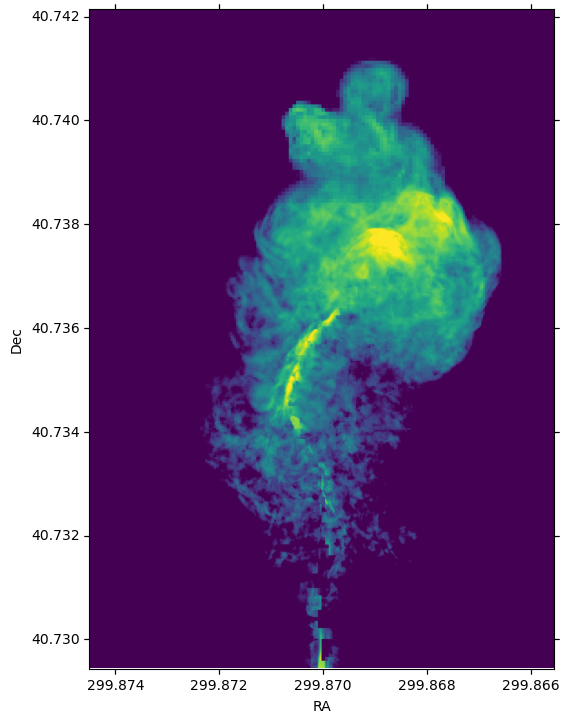

In [ ]:
wcs = WCS(hdu.header)

fig = plt.figure(figsize=(6,12))
fig.add_subplot(111, projection=wcs)
plt.imshow(np.log10(hdu.data+1e-3), vmin=-1, vmax=1, origin='lower')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

Now we have the sky coordinate for the image!

## 3. Prepare a Point Spread Function (PSF)

Simple PSFs are included in astropy.convolution.kernel. We'll use astropy.convolution.Gaussian2DKernel here. First we need to set the telescope resolution. For a 2D Gaussian, we can calculate sigma in pixels by using our pixel scale keyword cdelt2 from above.

In [ ]:
# assume our telescope has 1 arcsecond resolution
telescope_resolution = 1*u.arcsecond

# calculate the sigma in pixels. 
# since cdelt is in degrees, we use _.to('deg')
sigma = telescope_resolution.to('deg')/cdelt2
sigma

<Quantity 31.7488538>

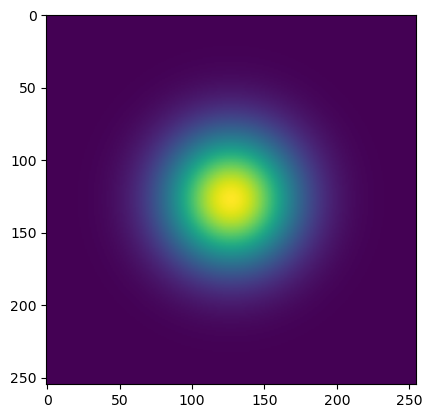

In [ ]:
# By default, the Gaussian kernel will go to 4 sigma
# in each direction
psf = Gaussian2DKernel(sigma)

# let's take a look:
plt.imshow(psf.array.value)
plt.show()

### 3.a How to do this without astropy kernels

Maybe your PSF is more complicated. Here's an alternative way to do this, using a 2D Lorentzian

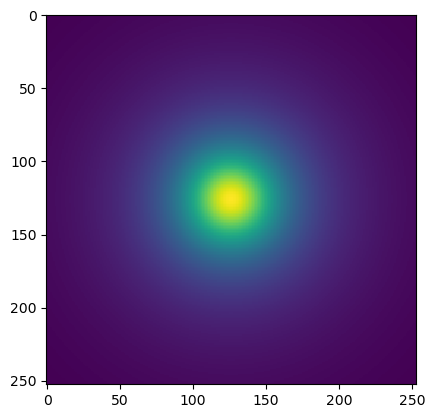

In [ ]:
# set FWHM and psf grid
telescope_resolution = 1*u.arcsecond
gamma = telescope_resolution.to('deg')/cdelt2
x_grid = np.outer(np.linspace(-gamma*4,gamma*4,int(8*gamma)),np.ones(int(8*gamma)))
r_grid = np.sqrt(x_grid**2 + np.transpose(x_grid**2))
lorentzian = Lorentz1D(fwhm=2*gamma)

# extrude a 2D azimuthally symmetric PSF
lorentzian_psf = lorentzian(r_grid)

# normalization
lorentzian_psf /= np.sum(lorentzian_psf)

# let's take a look again:
plt.imshow(lorentzian_psf.value, interpolation='none')
plt.show()

## 4. Convolve image with PSF

Here we use astropy.convolution.convolve_fft to convolve image. This routine uses fourier transform for faster calculation. Especially since our data is $2^n$ sized, which makes it particually fast. Using a fft, however, causes boundary effects. We'll need to specify how we want to handle the boundary. Here we choose to "wrap" the data, which means making the data periodic.

In [ ]:
convolved_image = convolve_fft(hdu.data, psf, boundary='wrap')

In [ ]:
# Put a psf at the corner of the image
delta_x_psf=100 # number of pixels from the edges
xmin, xmax = -psf.shape[1]-delta_x_psf, -delta_x_psf
ymin, ymax = delta_x_psf, delta_x_psf+psf.shape[0]
convolved_image[xmin:xmax, ymin:ymax] = psf.array/psf.array.max()*10

Now let's take a look at the convolved image.

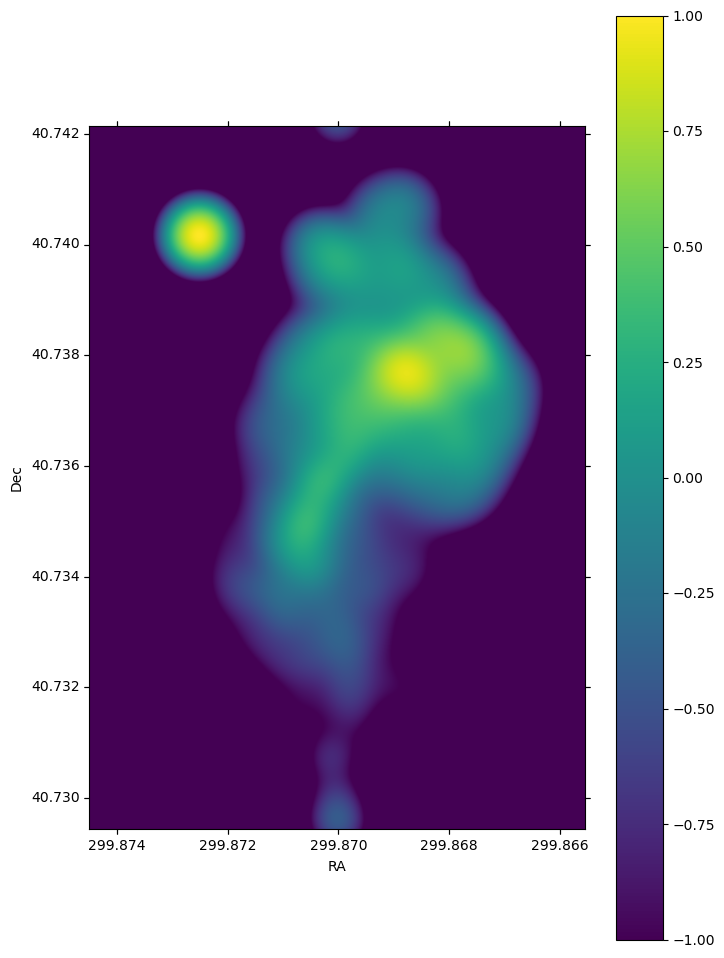

In [ ]:
wcs = WCS(hdu.header)
fig = plt.figure(figsize=(8,12))
i_plot = fig.add_subplot(111, projection=wcs)
plt.imshow(np.log10(convolved_image+1e-3), vmin=-1, vmax=1.0, origin='lower')#, cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()
plt.show()

## 5. Convolve Stokes Q and U images

In [ ]:
hdulist.info()

Filename: C:\Users\user\.astropy\cache\download\url\8da27de5aa6b0db633441e82715bedf3\contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  NN_EMISSIVITY_I_LOBE_150.0MHZ    1 ImageHDU        24   (1024, 1452)   float64   


In [ ]:
file_q = download_file(
    'http://data.astropy.org/tutorials/synthetic-images/synchrotron_q_lobe_0700_150MHz_sm.fits', 
    cache=True)
hdulist = fits.open(file_q)
hdu_q = hdulist['NN_EMISSIVITY_Q_LOBE_150.0MHZ']

file_u = download_file(
    'http://data.astropy.org/tutorials/synthetic-images/synchrotron_u_lobe_0700_150MHz_sm.fits', 
    cache=True)
hdulist = fits.open(file_u)
hdu_u = hdulist['NN_EMISSIVITY_U_LOBE_150.0MHZ']

# Update the header with the wcs_header we created earlier
hdu_q.header.update(wcs_header)
hdu_u.header.update(wcs_header)

# Convolve the images with the the psf
convolved_image_q = convolve_fft(hdu_q.data, psf, boundary='wrap')
convolved_image_u = convolve_fft(hdu_u.data, psf, boundary='wrap')

Let's plot the Q and U images.

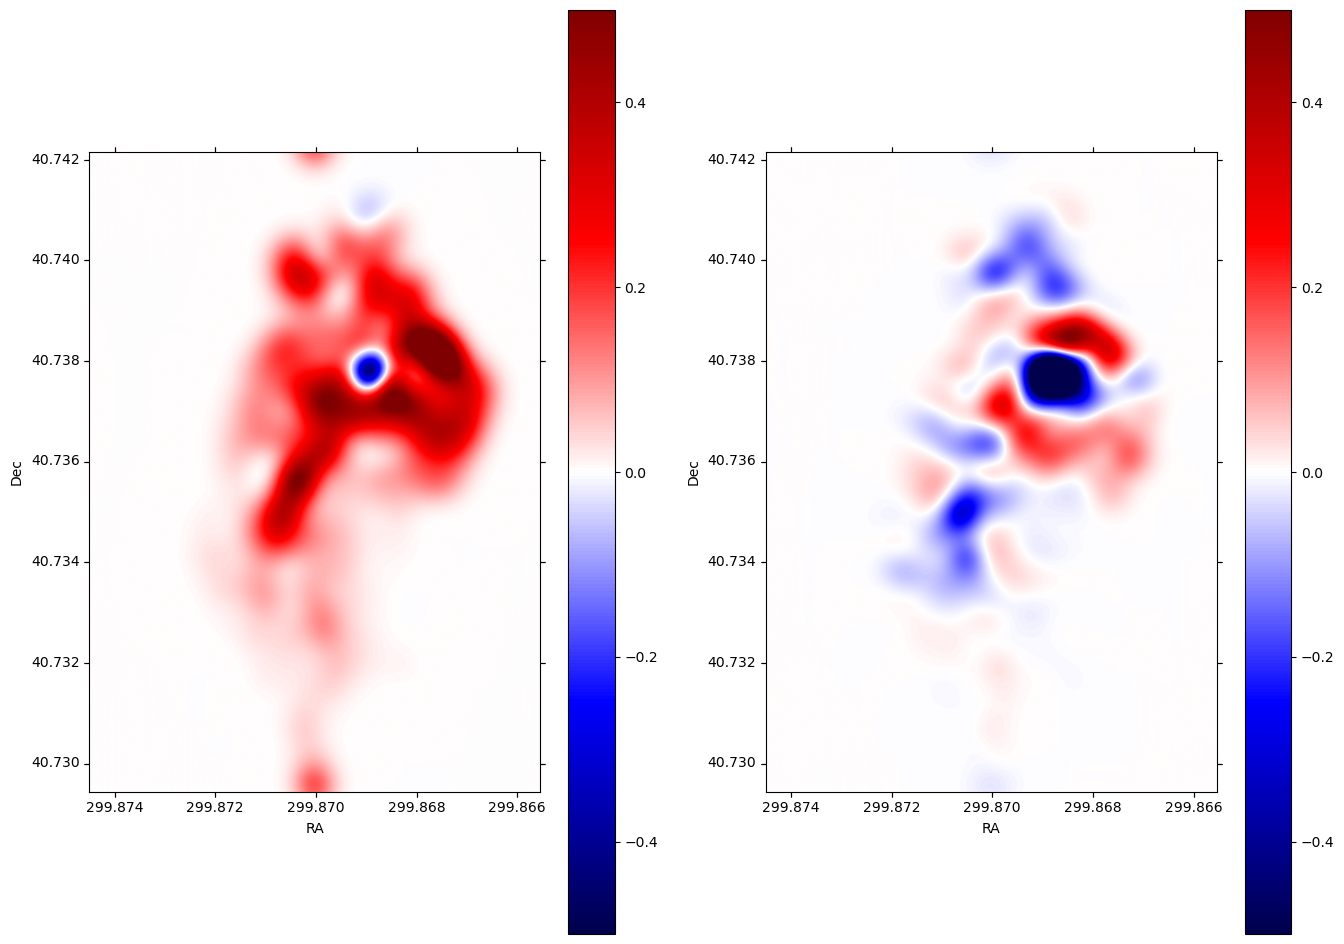

In [ ]:
wcs = WCS(hdu.header)
fig = plt.figure(figsize=(16,12))
fig.add_subplot(121, projection=wcs)
plt.imshow(convolved_image_q, cmap='seismic', vmin=-0.5, vmax=0.5, origin='lower')#, cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()

fig.add_subplot(122, projection=wcs)
plt.imshow(convolved_image_u, cmap='seismic', vmin=-0.5, vmax=0.5, origin='lower')#, cmap=plt.cm.viridis)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()

plt.show()

## 6. Calculate polarization angle and fraction for quiver plot

Note that rotating Stokes Q and I maps requires changing signs of both. Here we assume that the Stokes q and u maps were calculated defining the y/declination axis as vertical, such that Q is positive for polarization vectors along the x/right-ascention axis.

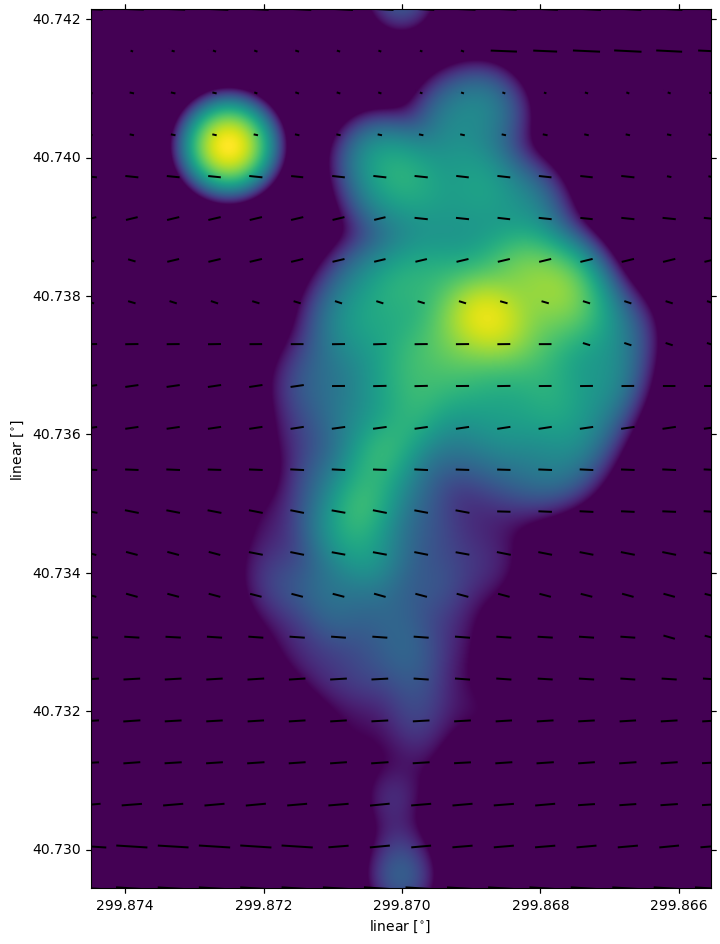

In [ ]:
# First, we plot the background image
fig = plt.figure(figsize=(8,16))
i_plot = fig.add_subplot(111, projection=wcs)
i_plot.imshow(np.log10(convolved_image+1e-3), vmin=-1, vmax=1, origin='lower')

# ranges of the axis
xx0, xx1 = i_plot.get_xlim()
yy0, yy1 = i_plot.get_ylim()

# binning factor
factor = [64, 66]

# re-binned number of points in each axis
nx_new = convolved_image.shape[1] // factor[0]
ny_new = convolved_image.shape[0] // factor[1]

# These are the positions of the quivers
X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                  np.linspace(yy0,yy1,ny_new,endpoint=True))

# bin the data
I_bin = convolved_image.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
Q_bin = convolved_image_q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
U_bin = convolved_image_u.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)

# polarization angle
psi = 0.5*np.arctan2(U_bin, Q_bin)

# polarization fraction
frac = np.sqrt(Q_bin**2+U_bin**2)/I_bin

# mask for low signal area
mask = I_bin < 0.1

frac[mask] = 0
psi[mask] = 0

pixX = frac*np.cos(psi) # X-vector 
pixY = frac*np.sin(psi) # Y-vector

# keyword arguments for quiverplots
quiveropts = dict(headlength=0, headwidth=1, pivot='middle')
i_plot.quiver(X, Y, pixX, pixY, scale=8, **quiveropts)
plt.show()